# CrabNet predictions

In [1]:
import numpy as np
import pandas as pd
import pickle
import ast
import requests
import re
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
from crabnet.crabnet_ import CrabNet
from crabnet.utils.figures import act_pred
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data preparation

In [2]:
df = pd.read_csv('data_RO2/df_ml_ready.csv')
df.head()

,reduced_formulas,etl,htl,bandgap,device_stack,pce,etl_SMILES,htl_SMILES
0,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"['O=[Ti]=O', 'O=[Ti]=O']",['CCCCCCC1=CSC=C1']
1,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['PTB7-th'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"['O=[Ti]=O', 'O=[Ti]=O']",['CCC(=CF)COC1=CC=C(C=C1)C23CCC(CC2)(CC3)C(=O)...
2,Ag2BiI5,"['TiO2-c', 'TiO2-mp']",['PTAA'],2.22,"['SLG', 'ITO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.60,"['O=[Ti]=O', 'O=[Ti]=O']",['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']
3,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.80,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.32,"['O=[Ti]=O', 'O=[Ti]=O']",['CCCCCCC1=CSC=C1']
4,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['PTAA'],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",4.30,"['O=[Ti]=O', 'O=[Ti]=O']",['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']


## Label encoding for string variables

In [3]:
# Get the unique values
device_values = df['device_stack'].unique()
etl_values = df['etl'].unique()
htl_values = df['htl'].unique()

# Create a dictionary mapping each value to an integer
device_dict = {value: index for index, value in enumerate(device_values)}
etl_dict = {value: index for index, value in enumerate(etl_values)}
htl_dict = {value: index for index, value in enumerate(htl_values)}

# Replace each value with its corresponding integer
df_encoded = df.copy()
df_encoded['device_stack_encoded'] = df['device_stack'].map(device_dict)
df_encoded['etl_encoded'] = df['etl'].map(etl_dict)
df_encoded['htl_encoded'] = df['htl'].map(htl_dict)

df_encoded.rename(columns={'pce': 'target'}, inplace=True)
df_encoded.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

## Train test split
Splitting is done according to a pre-defined shufflex index to ensure the same split in all models.

In [4]:
# Load the splitting indices to make sure all models split the same way
with open("data_RO2/index_for_train_test_split.pkl", "rb") as f:
    splitting_indices = pickle.load(f)

df_encoded = df_encoded.iloc[splitting_indices]

# Train/test/val split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate sizes based on ratios
total_size = len(df_encoded)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
train_val_size = train_size + val_size
test_size = total_size - train_size - val_size

# Split the data
train_df = df_encoded[:train_size]
val_df = df_encoded[train_size:train_size+val_size]
test_df = df_encoded[train_val_size:]

train_df = train_df.drop(columns=['etl','htl', 'device_stack','etl_SMILES','htl_SMILES', 'device_stack_encoded'])
val_df = val_df.drop(columns=['etl','htl', 'device_stack','etl_SMILES','htl_SMILES', 'device_stack_encoded'])
test_df = test_df.drop(columns=['etl','htl', 'device_stack','etl_SMILES','htl_SMILES', 'device_stack_encoded'])

# CrabNet predictions

## Absorber only


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 4339/4339 [00:00<00:00, 95279.18formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 542/542 [00:00<00:00, 104184.82formulae/s]


loading data with up to 9 elements in the formula
stepping every 170 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 3.98 val mae: 4.02


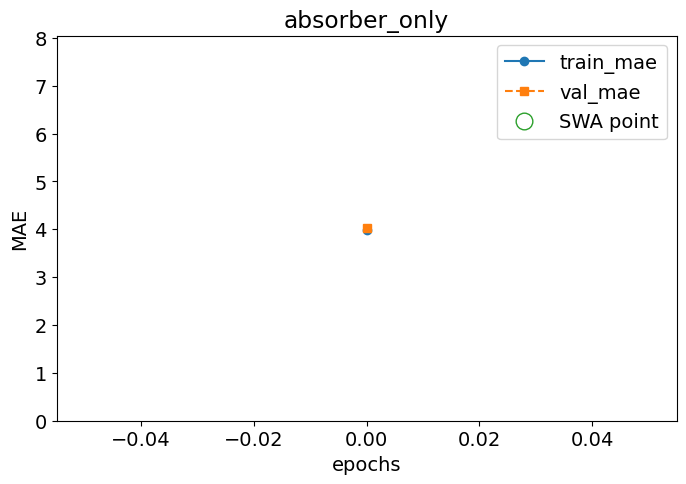

Epoch: 19/300 --- train mae: 2.74 val mae: 3.01


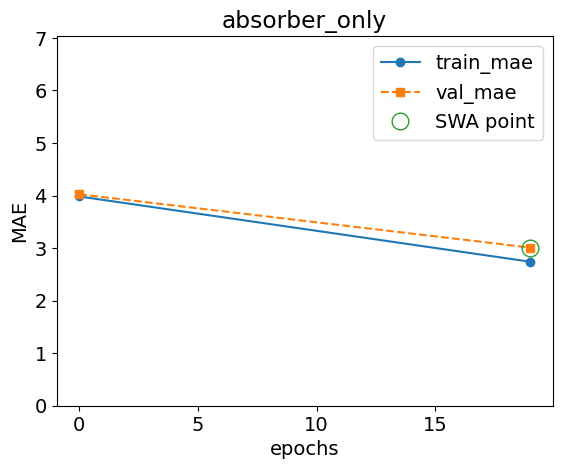

Epoch: 39/300 --- train mae: 2.55 val mae: 3


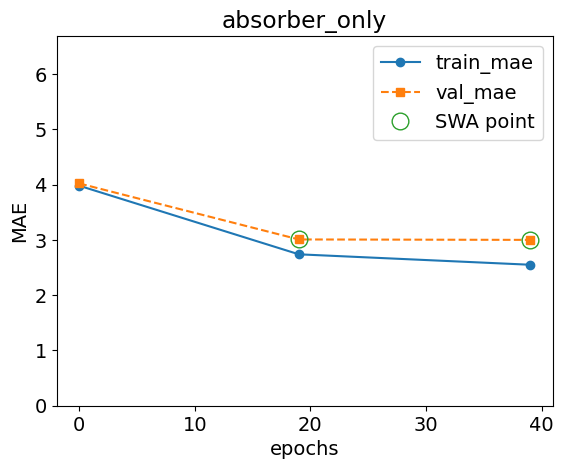

Epoch: 59/300 --- train mae: 2.46 val mae: 3.01


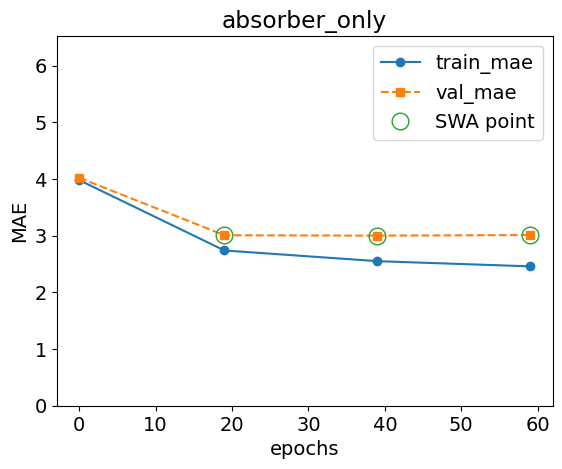

Epoch: 79/300 --- train mae: 2.4 val mae: 3.01


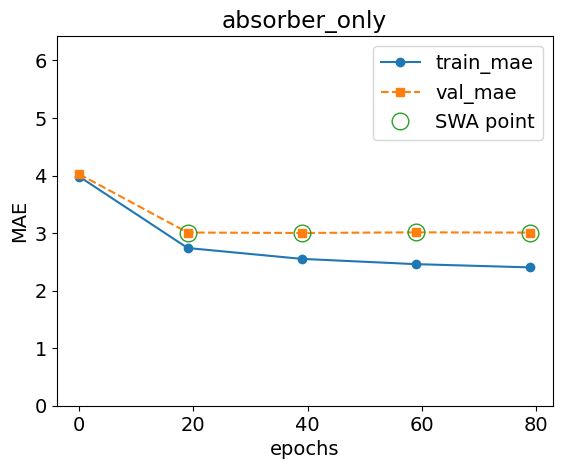

Epoch: 99/300 --- train mae: 2.37 val mae: 3.02


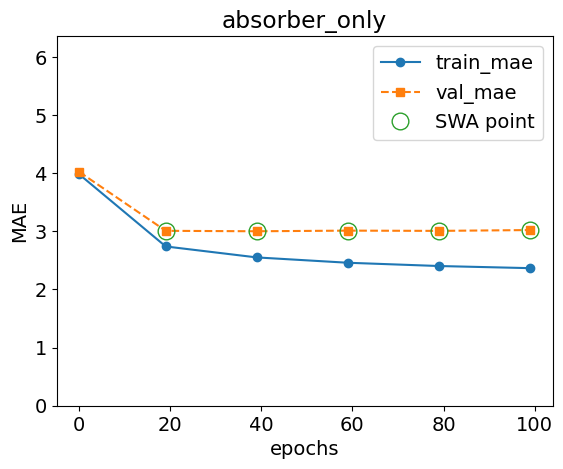

Epoch: 119/300 --- train mae: 2.36 val mae: 3.01


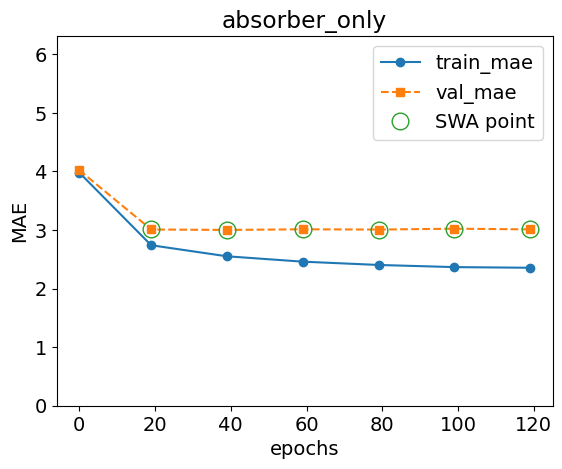

Epoch: 139/300 --- train mae: 2.34 val mae: 3


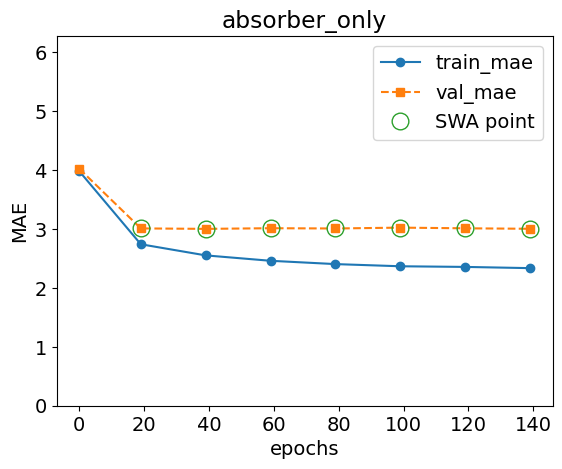

Epoch: 159/300 --- train mae: 2.32 val mae: 3.02


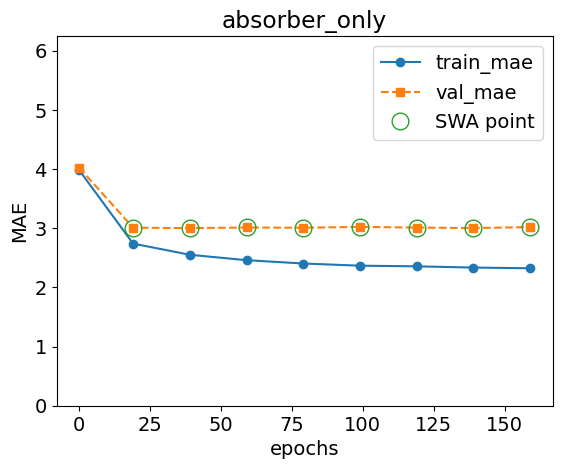

Epoch 179 failed to improve.
Discarded: 1/3 weight updates
Epoch: 179/300 --- train mae: 2.32 val mae: 3.04


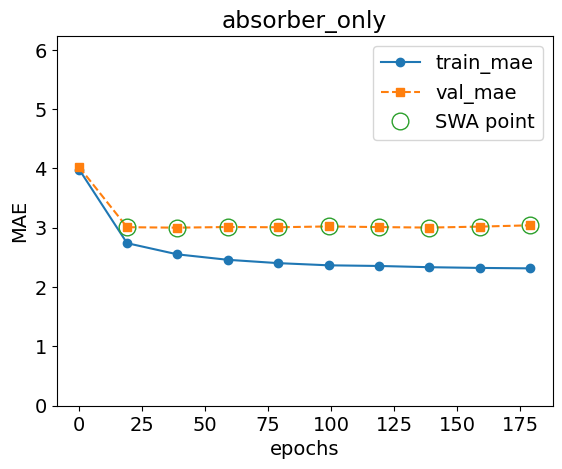

Epoch: 199/300 --- train mae: 2.31 val mae: 3.03


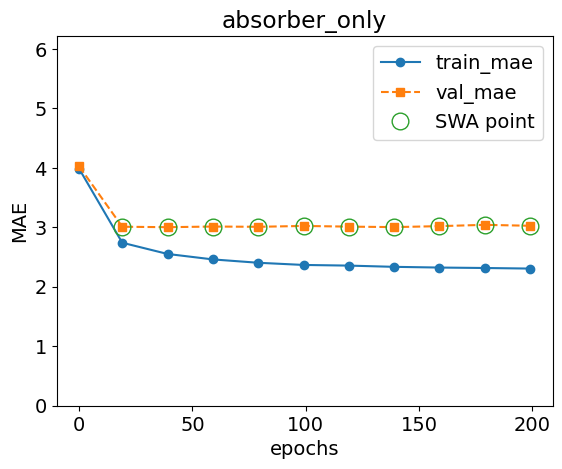

Epoch: 219/300 --- train mae: 2.31 val mae: 3.03


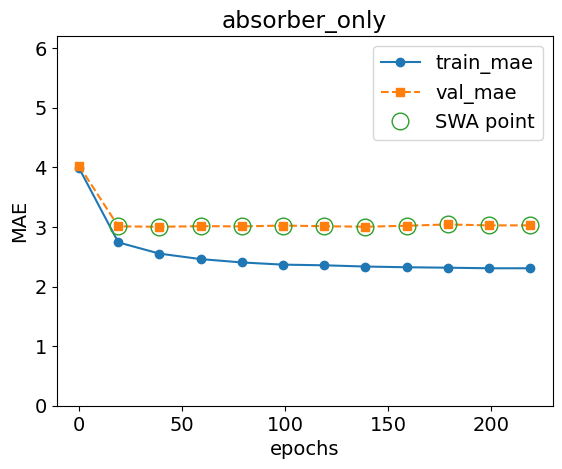

Epoch: 239/300 --- train mae: 2.3 val mae: 3.02


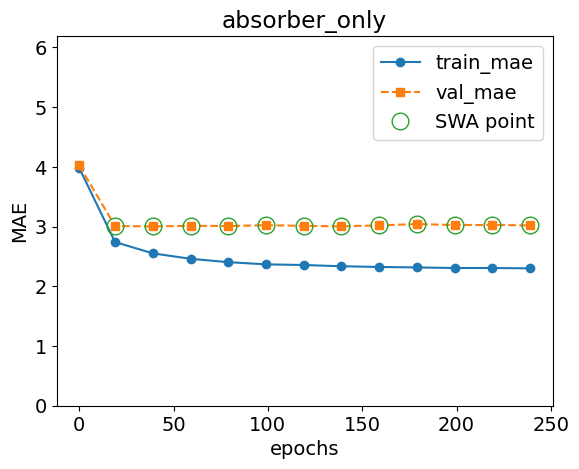

Epoch 259 failed to improve.
Discarded: 2/3 weight updates
Epoch: 259/300 --- train mae: 2.3 val mae: 3.04


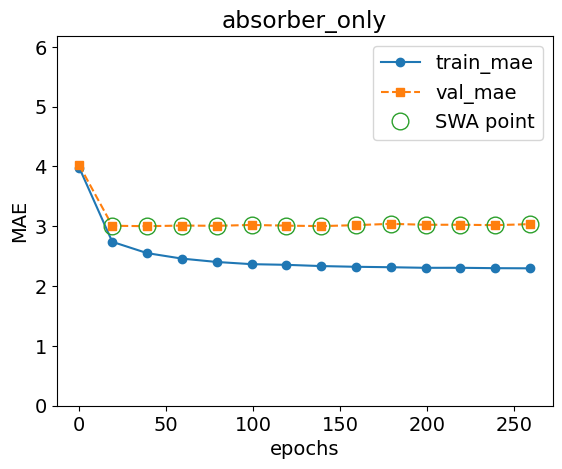

Epoch 279 failed to improve.
Discarded: 3/3 weight updates
Epoch: 279/300 --- train mae: 2.29 val mae: 3.04


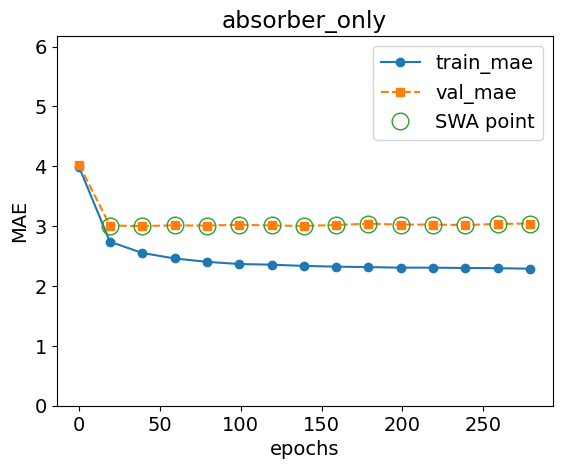

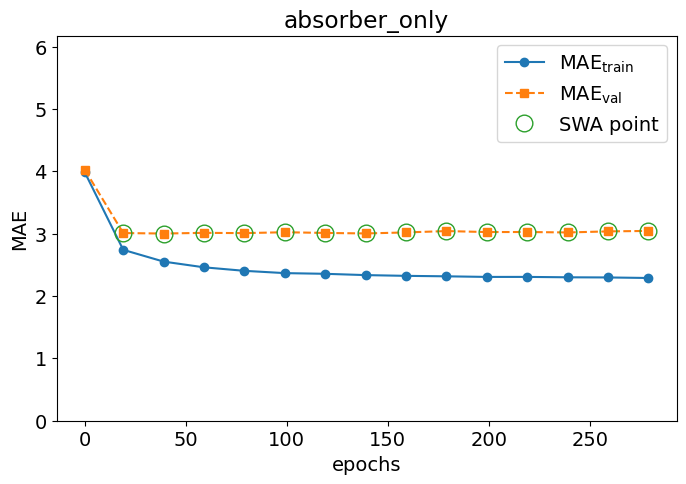

Discarded: 3/3weight updates, early-stopping now
Saving network (absorber_only) to models/trained_models/absorber_only.pth


In [5]:
cb_absorber_only = CrabNet(mat_prop="pce",
                           model_name='absorber_only',
                           elem_prop='mat2vec', 
                           learningcurve=True,
                           extend_features=['bandgap'])
cb_absorber_only.fit(train_df, val_df)

Generating EDM: 100%|██████████| 543/543 [00:00<00:00, 126408.78formulae/s]


loading data with up to 9 elements in the formula


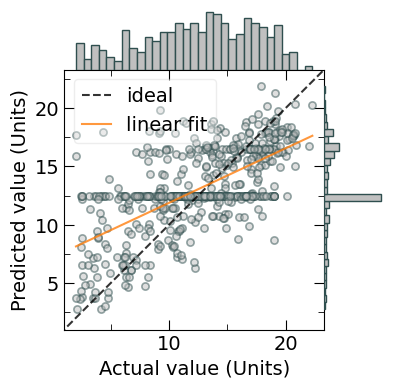

R2 score: 0.3920191021222079
MSE: 14.19403418762317
MAE: 2.892870745858834


In [6]:
# Predictions
pred_df = test_df

df_predicted, df_predicted_sigma = cb_absorber_only.predict(test_df, return_uncertainty=True)

act_pred(test_df['target'], df_predicted)
r2 = r2_score(test_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(test_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(test_df['target'], df_predicted)
print(f'MAE: {mae}')

### Save predictions for model comparison ANOVA

In [7]:
crabnet_predictions = pd.DataFrame()
crabnet_predictions['predicted'] = df_predicted
crabnet_predictions['true_values'] = list(test_df['target'])

crabnet_predictions.to_csv('data_RO2/CrabNet_abs_only_predictions.csv', index=False)

## Absorber + label encoded etl, htl and device stack

For some odd reason it can happen that you cannot execute this after having trained another CrabNet model. In that case, restart the kernel first and then skip training the first model. (see: https://stackoverflow.com/questions/77358007/instantiating-various-crabnet-models-in-same-code)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 4339/4339 [00:00<00:00, 141820.26formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 542/542 [00:00<00:00, 137768.18formulae/s]


loading data with up to 9 elements in the formula
stepping every 170 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 3.99 val mae: 4.03


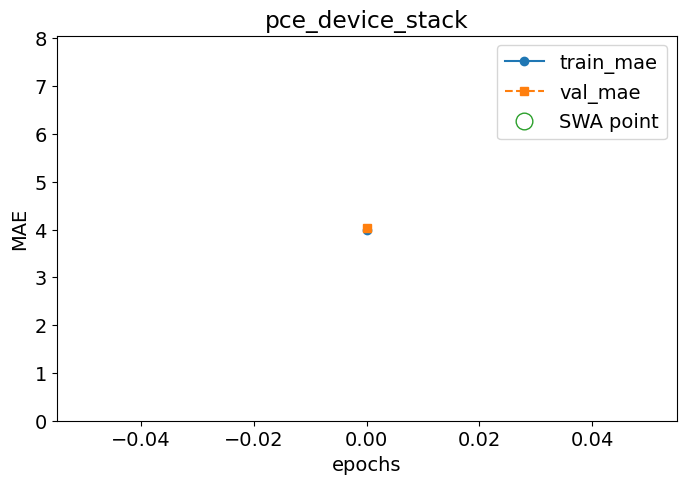

Epoch: 19/300 --- train mae: 2.78 val mae: 3.06


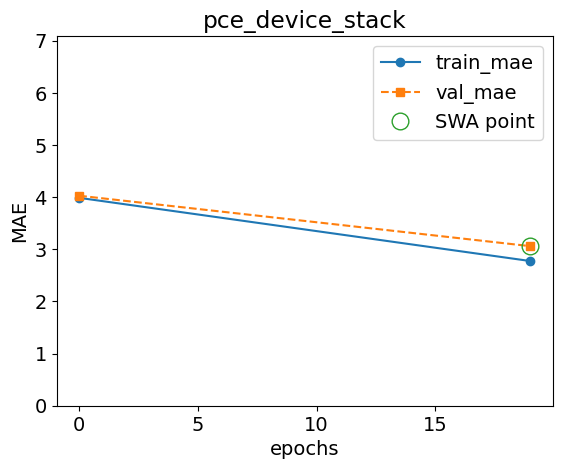

Epoch: 39/300 --- train mae: 2.58 val mae: 3.04


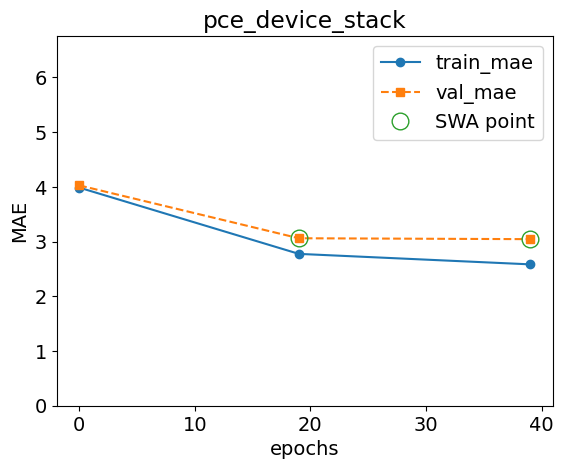

Epoch: 59/300 --- train mae: 2.47 val mae: 3.01


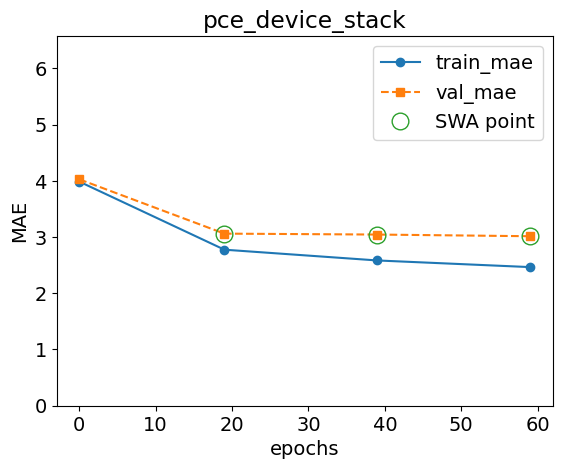

Epoch: 79/300 --- train mae: 2.41 val mae: 3.01


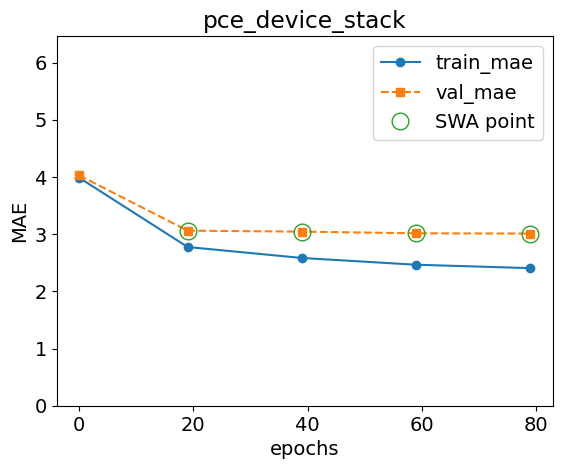

Epoch 99 failed to improve.
Discarded: 1/3 weight updates
Epoch: 99/300 --- train mae: 2.37 val mae: 3.04


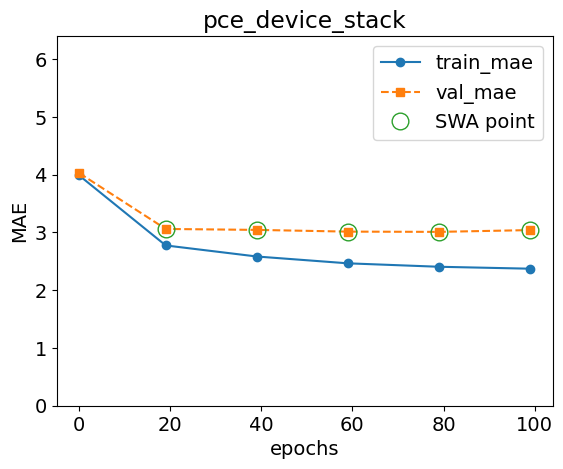

Epoch: 119/300 --- train mae: 2.36 val mae: 3.01


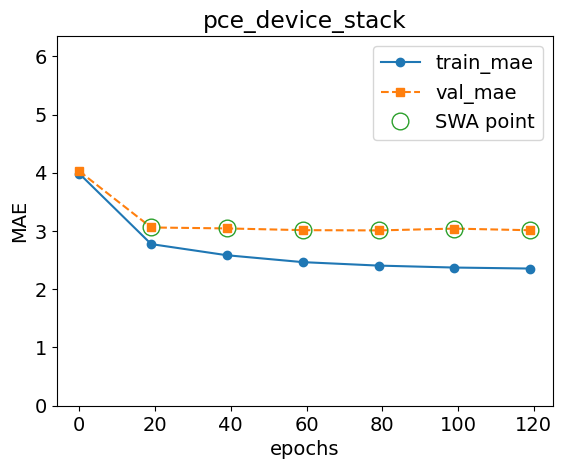

Epoch: 139/300 --- train mae: 2.34 val mae: 3.02


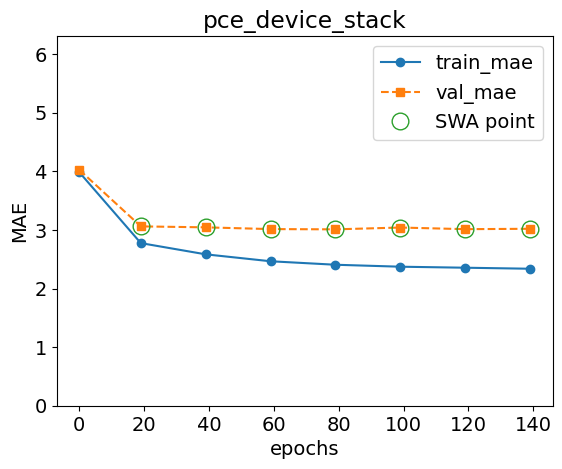

Epoch: 159/300 --- train mae: 2.33 val mae: 3.03


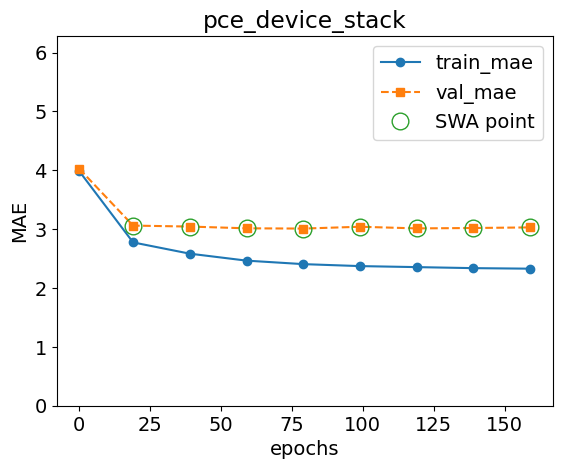

Epoch: 179/300 --- train mae: 2.32 val mae: 3.04


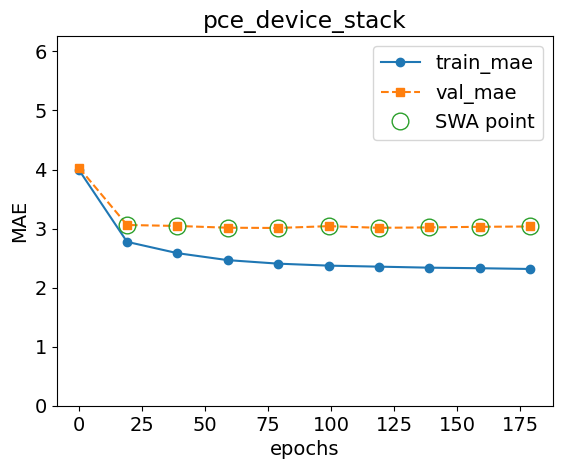

Epoch: 199/300 --- train mae: 2.31 val mae: 3.02


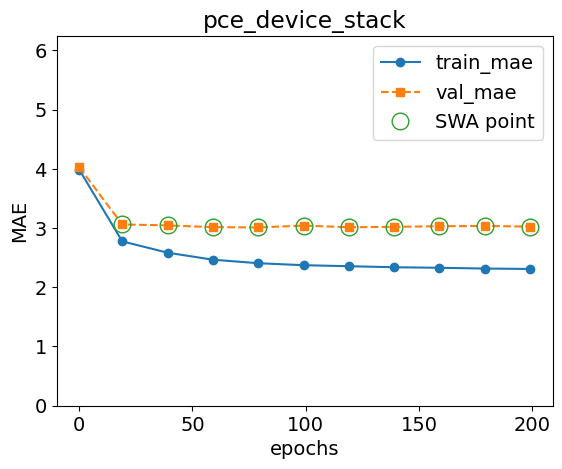

Epoch: 219/300 --- train mae: 2.3 val mae: 3.01


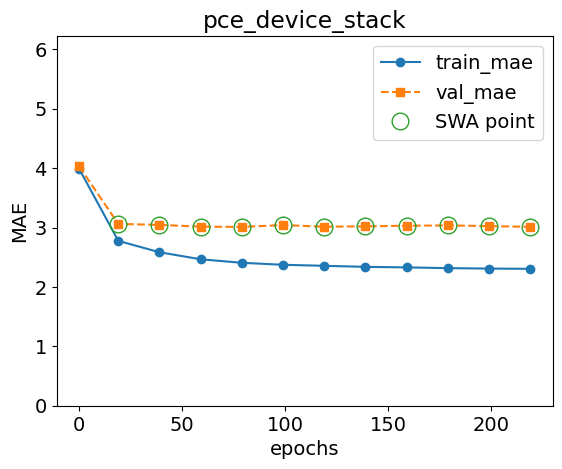

Epoch: 239/300 --- train mae: 2.3 val mae: 3.01


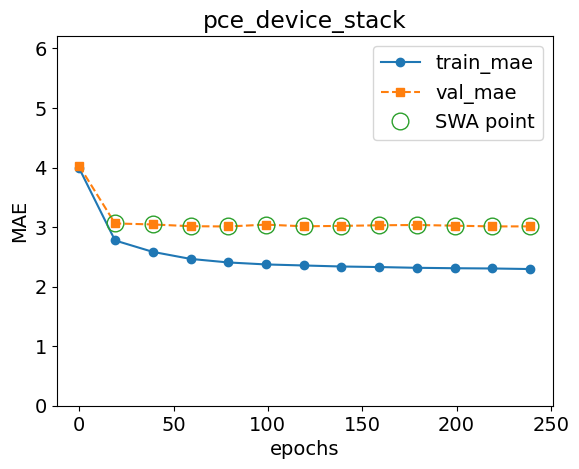

Epoch: 259/300 --- train mae: 2.3 val mae: 3.03


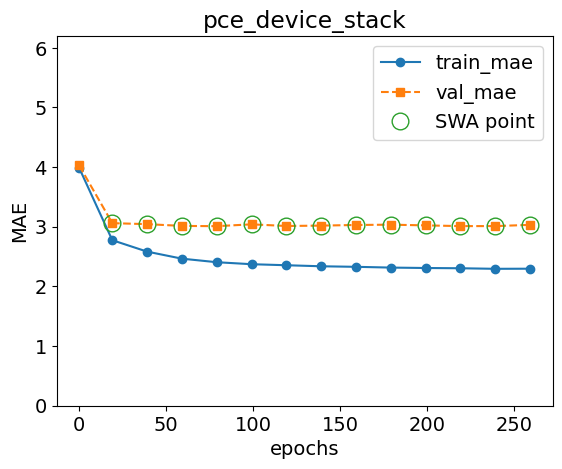

Epoch 279 failed to improve.
Discarded: 2/3 weight updates
Epoch: 279/300 --- train mae: 2.29 val mae: 3.04


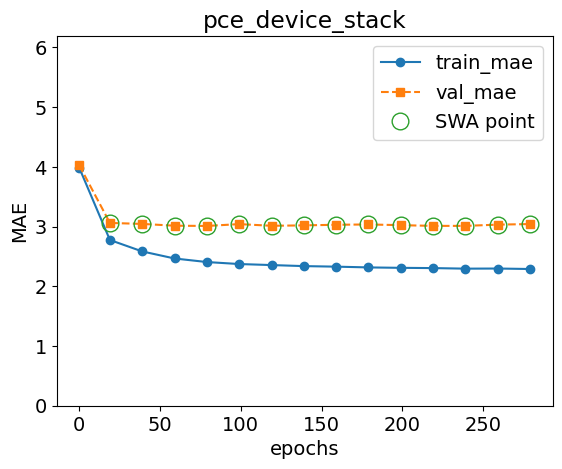

Epoch 299 failed to improve.
Discarded: 3/3 weight updates
Epoch: 299/300 --- train mae: 2.29 val mae: 3.04


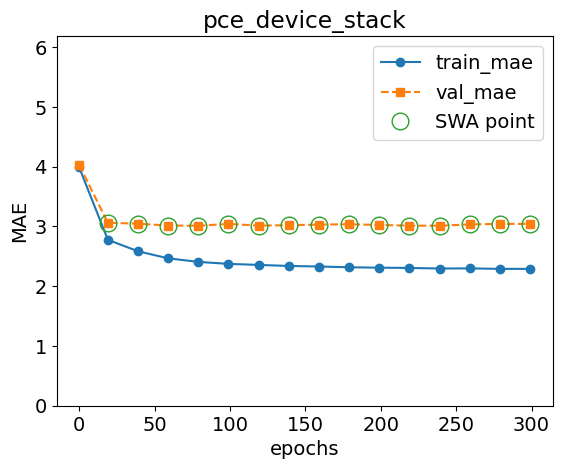

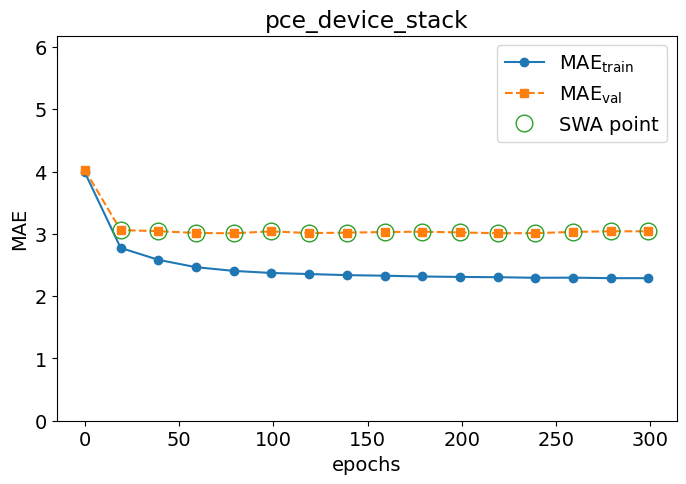

Discarded: 3/3weight updates, early-stopping now
Saving network (pce_device_stack) to models/trained_models/pce_device_stack.pth


In [8]:
cb_labels = CrabNet(mat_prop="pce",
                    model_name='pce_device_stack',
                    elem_prop='mat2vec', 
                    learningcurve=True, 
                    extend_features=["etl_encoded", "htl_encoded", "bandgap"])
cb_labels.fit(train_df, val_df)

Generating EDM: 100%|██████████| 543/543 [00:00<00:00, 134382.06formulae/s]


loading data with up to 9 elements in the formula


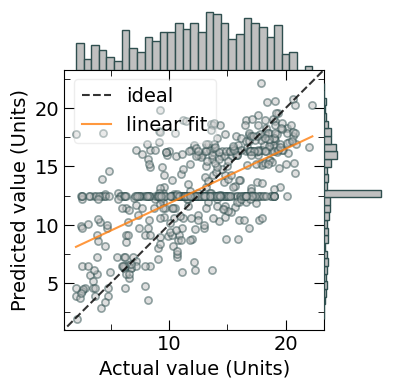

R2 score: 0.38165690131851737
MSE: 14.435952038956986
MAE: 2.9202773478905253


In [9]:
# Predictions
pred_df = test_df

pred_df_zeros = pd.DataFrame(({"formula": pred_df['formula'],
                               "target": [0.0]*len(pred_df['formula']),
                               "bandgap": pred_df['bandgap'],
                               "etl_encoded": pred_df['etl_encoded'],
                               "htl_encoded": pred_df['htl_encoded']}))
df_predicted, df_predicted_sigma = cb_labels.predict(pred_df_zeros, return_uncertainty=True)

act_pred(pred_df['target'], df_predicted)
r2 = r2_score(pred_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(pred_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(pred_df['target'], df_predicted)
print(f'MAE: {mae}')

### Save predictions for model comparison ANOVA

In [10]:
crabnet_predictions = pd.DataFrame()
crabnet_predictions['predicted'] = df_predicted
crabnet_predictions['true_values'] = list(test_df['target'])

crabnet_predictions.to_csv('data_RO2/CrabNet_labels_predictions.csv', index=False)

## Absorber and Fingerprints

### Specific data preparation

In [11]:
etl_combined_SMILES = []
htl_combined_SMILES = []

# Convert the SMILES strings to lists
df['etl_SMILES'] = df['etl_SMILES'].apply(ast.literal_eval)
df['htl_SMILES'] = df['htl_SMILES'].apply(ast.literal_eval)

# Combine the SMILES strings into a single string
for index, row in df.iterrows():
    etl_combination = ".".join(row['etl_SMILES'])
    htl_combination = ".".join(row['htl_SMILES'])
    etl_combined_SMILES.append(etl_combination)
    htl_combined_SMILES.append(htl_combination)
df['etl_combined_SMILES'] = etl_combined_SMILES
df['htl_combined_SMILES'] = htl_combined_SMILES

df['etl_combined_SMILES'] = df['etl_combined_SMILES'].str.replace('no_ctl', '')
df['htl_combined_SMILES'] = df['htl_combined_SMILES'].str.replace('no_ctl', '')

# Fingerprint generation
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

def smiles_to_fingerprint(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.zeros(fpgen.GetNumBits(),)
    fp = fpgen.GetFingerprint(molecule)
    # Convert to a bit vector
    bit_vector = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, bit_vector)
    return bit_vector

# Create columns for Morgan Fingerprints
etl_fingerprints = df['etl_combined_SMILES'].apply(smiles_to_fingerprint)
htl_fingerprints = df['htl_combined_SMILES'].apply(smiles_to_fingerprint)

# Convert fingerprints to DataFrame
etl_fingerprint_df = pd.DataFrame(etl_fingerprints.tolist(), columns=[f'ETL_FP_{i}' for i in range(1024)])
htl_fingerprint_df = pd.DataFrame(htl_fingerprints.tolist(), columns=[f'HTL_FP_{i}' for i in range(1024)])

# Combine all features into a single DataFrame
features_df = pd.DataFrame
features_df = pd.concat([df.drop(columns=['etl', 
                                          'htl', 
                                          'etl_SMILES',
                                          'htl_SMILES',
                                          'etl_combined_SMILES',
                                          'htl_combined_SMILES']), etl_fingerprint_df, htl_fingerprint_df], axis=1)

print(len(features_df))
features_df = features_df.dropna()
print(len(features_df))

features_df.rename(columns={'pce': 'target'}, inplace=True)
features_df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

[15:46:19] WARNING: not removing hydrogen atom without neighbors
[15:46:35] WARNING: not removing hydrogen atom without neighbors
[15:46:35] WARNING: not removing hydrogen atom without neighbors


5424
5424


### Train test split

In [12]:
# Load the splitting indices to make sure all models split the same way
with open("data_RO2/index_for_train_test_split.pkl", "rb") as f:
    splitting_indices = pickle.load(f)

features_df = features_df.iloc[splitting_indices]

# Train/test/val split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate sizes based on ratios
total_size = len(features_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
train_val_size = train_size + val_size
test_size = total_size - train_size - val_size

# Split the data
fp_train_df = features_df[:train_size]
fp_val_df = features_df[train_size:val_size+train_size]
print(train_size)
print(val_size)
fp_test_df = features_df[train_val_size:]

4339
542


### CrabNet Training


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



/opt/conda/lib/python3.10/site-packages/crabnet/utils/utils.py:486: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "count"] = [
Generating EDM: 100%|██████████| 4339/4339 [00:00<00:00, 130037.12formulae/s]

loading data with up to 9 elements in the formula



/opt/conda/lib/python3.10/site-packages/crabnet/utils/utils.py:486: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "count"] = [


training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 542/542 [00:00<00:00, 124387.87formulae/s]


loading data with up to 9 elements in the formula
stepping every 170 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 3.97 val mae: 4.02


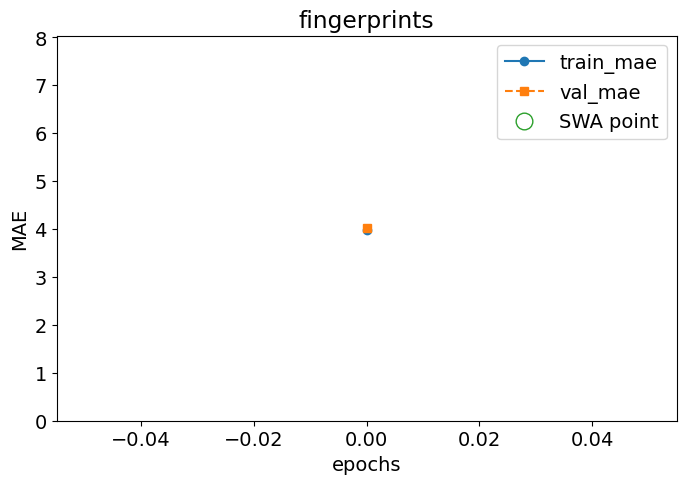

Epoch: 19/300 --- train mae: 2.76 val mae: 3.03


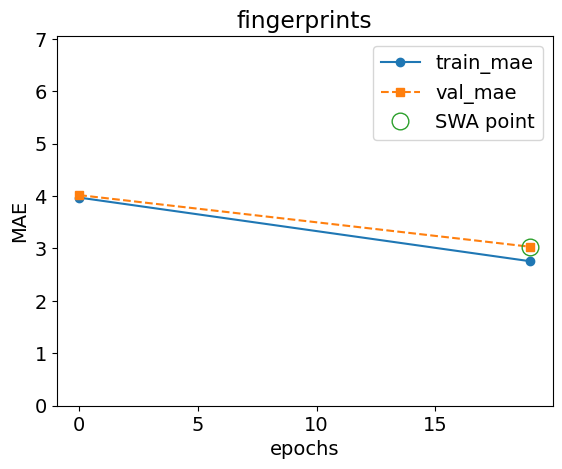

Epoch: 39/300 --- train mae: 2.57 val mae: 3


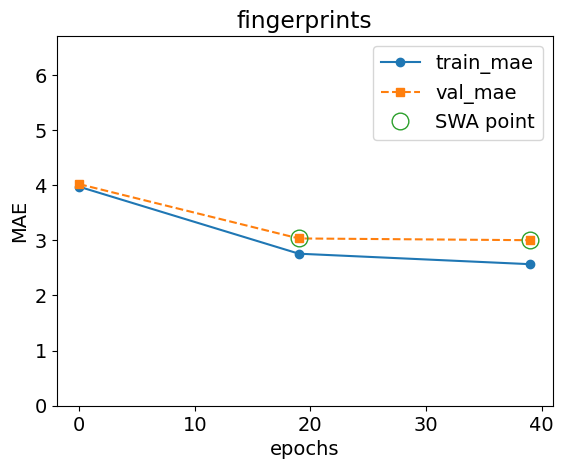

Epoch: 59/300 --- train mae: 2.46 val mae: 3.03


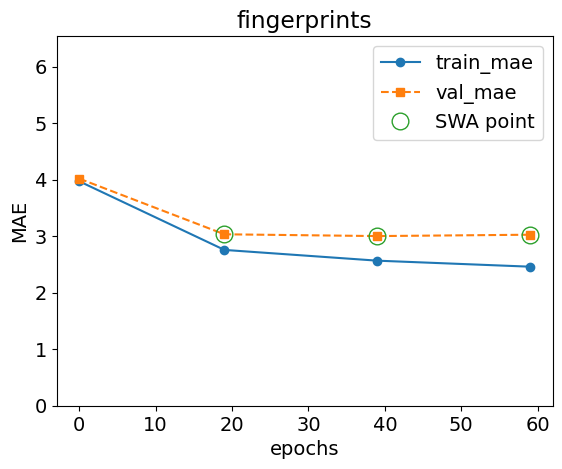

Epoch: 79/300 --- train mae: 2.4 val mae: 3.01


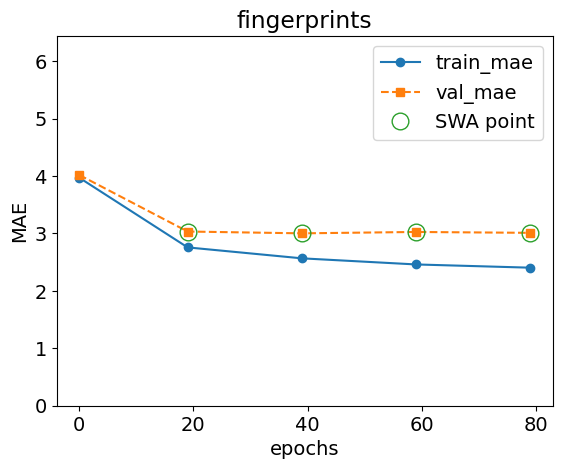

Epoch: 99/300 --- train mae: 2.37 val mae: 3.01


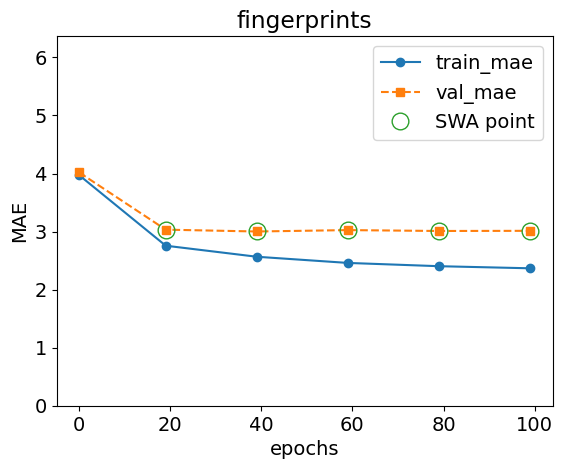

Epoch: 119/300 --- train mae: 2.35 val mae: 3.03


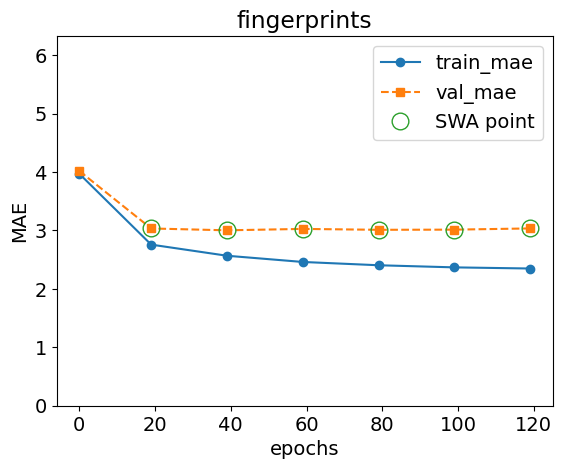

Epoch 139 failed to improve.
Discarded: 1/3 weight updates
Epoch: 139/300 --- train mae: 2.34 val mae: 3.04


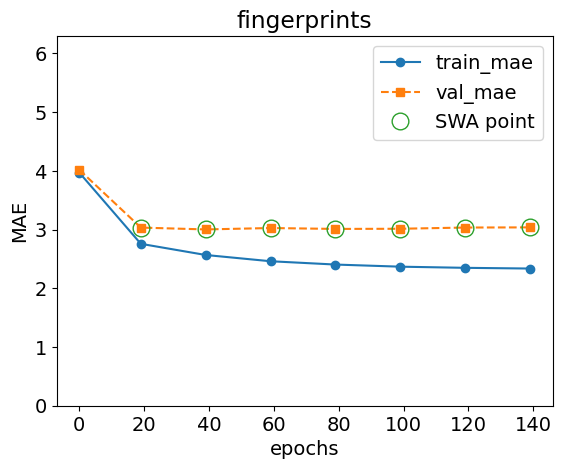

Epoch: 159/300 --- train mae: 2.32 val mae: 3.02


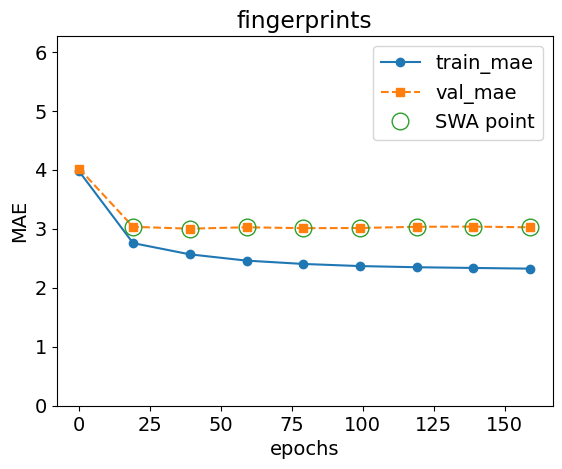

Epoch: 179/300 --- train mae: 2.31 val mae: 3.03


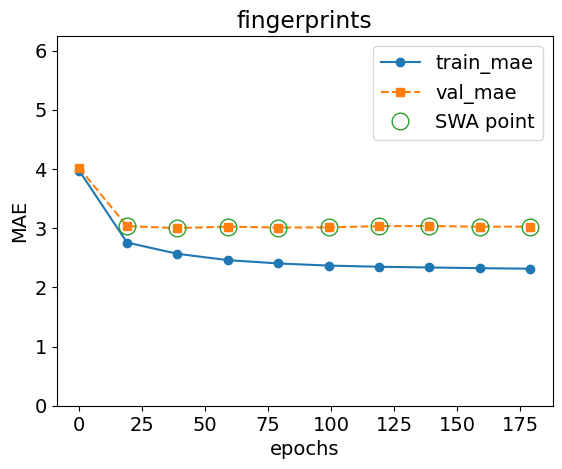

Epoch 199 failed to improve.
Discarded: 2/3 weight updates
Epoch: 199/300 --- train mae: 2.3 val mae: 3.03


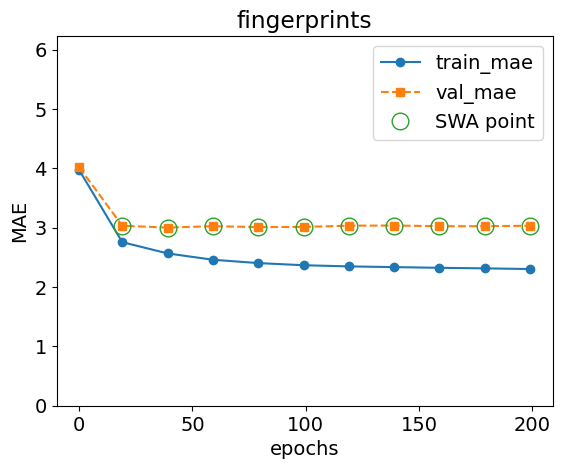

Epoch: 219/300 --- train mae: 2.3 val mae: 3.03


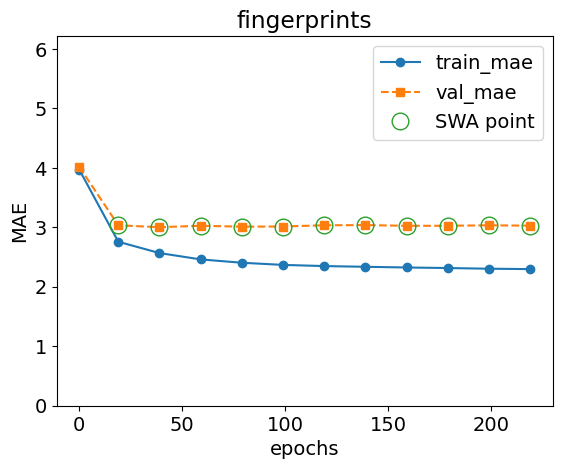

Epoch: 239/300 --- train mae: 2.3 val mae: 3.02


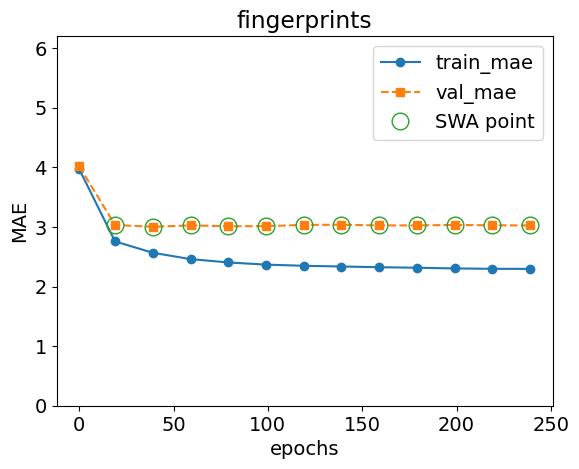

Epoch: 259/300 --- train mae: 2.29 val mae: 3.03


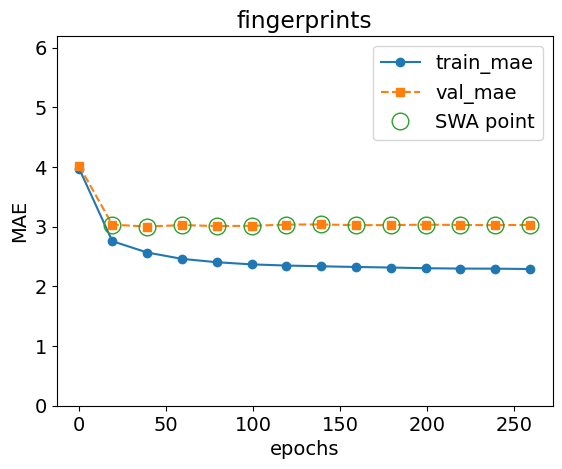

Epoch 279 failed to improve.
Discarded: 3/3 weight updates
Epoch: 279/300 --- train mae: 2.28 val mae: 3.05


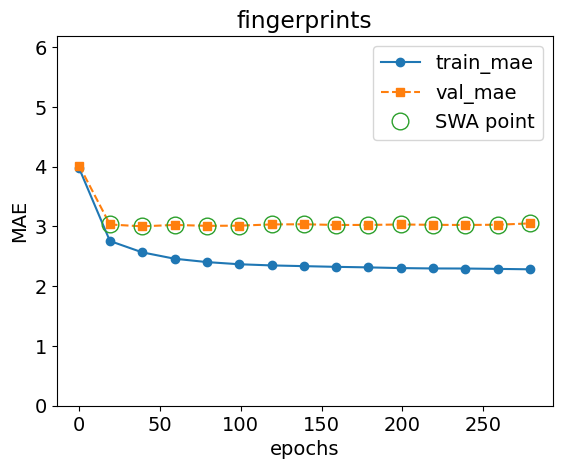

Discarded: 3/3weight updates, early-stopping now
Saving network (fingerprints) to models/trained_models/fingerprints.pth


In [14]:
fingerprints = list(features_df.columns[3:2052])

cb_fingerprints = CrabNet(mat_prop="pce",
                          model_name='fingerprints',
                          elem_prop='mat2vec', 
                          learningcurve=False, 
                          extend_features=fingerprints)
cb_fingerprints.fit(fp_train_df, fp_val_df)

/opt/conda/lib/python3.10/site-packages/crabnet/utils/utils.py:486: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "count"] = [
Generating EDM: 100%|██████████| 543/543 [00:00<00:00, 134843.52formulae/s]


loading data with up to 9 elements in the formula


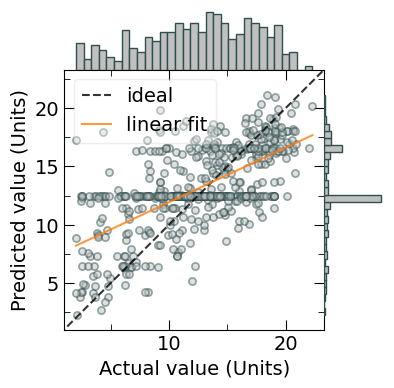

R2 score: 0.39134638219900963
MSE: 14.209739631037433
MAE: 2.899987909339589


In [15]:
# Predictions
y_pred, y_pred_sigma = cb_fingerprints.predict(fp_test_df, return_uncertainty=True)

# Plot
act_pred(fp_test_df['target'], y_pred)

# Statistics
r2 = r2_score(fp_test_df['target'], y_pred)
print(f'R2 score: {r2}')
mse = mean_squared_error(fp_test_df['target'], y_pred)
print(f'MSE: {mse}')
mae = mean_absolute_error(fp_test_df['target'], y_pred)
print(f'MAE: {mae}')

# Save predictions for model comparison ANOVA

In [16]:
crabnet_predictions = pd.DataFrame()
crabnet_predictions['predicted'] = df_predicted
crabnet_predictions['true_values'] = list(test_df['target'])

crabnet_predictions.to_csv('data_RO2/CrabNet_full_predictions.csv', index=False)